In [25]:
# --- 1. IMPORTS & SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, f1_score)

# Visualization styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

print("Step 1: Libraries loaded.")

Step 1: Libraries loaded.


Cell 2: Data Loading & Preprocessing

This cell loads the aggregated data, handles missing values, and splits the data. We use Stratified Splitting to maintain the fraud ratio.

In [26]:
# --- 2. DATA LOADING & PREPROCESSING ---

# Load the aggregated provider data
# Ensure 'provider_features_for_modeling.csv' is in your working directory
try:
    df_final = pd.read_csv('provider_features_for_modeling.csv')
    print(f"Step 2: Dataset loaded. Shape: {df_final.shape}")
except FileNotFoundError:
    print("Error: 'provider_features_for_modeling.csv' not found. Please upload the file.")

# A. Target Encoding
# Convert 'Yes'/'No' to 1/0 for binary classification
df_final['PotentialFraud'] = df_final['PotentialFraud'].map({'Yes': 1, 'No': 0})

# B. Missing Value Imputation
# 'AvgLengthOfStay' has NaNs for providers with only outpatient claims (no hospital stay).
# We fill with 0 to preserve this pattern as a meaningful signal.
df_final = df_final.fillna(0)

# C. Feature Selection
# Drop IDs and Target to isolate features
X = df_final.drop(['Provider', 'PotentialFraud'], axis=1)
y = df_final['PotentialFraud']

# D. Stratified Train-Test Split
# We use stratification because fraud is a minority class (~9%).
# Random splitting could result in a test set with no fraud cases.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# E. Scaling
# Standard scaling helps Logistic Regression convergence and standardizes feature influence.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data Split: Train size {X_train.shape[0]}, Test size {X_test.shape[0]}")
print(f"Fraud proportion in Test set: {y_test.mean():.2%}")

Step 2: Dataset loaded. Shape: (5410, 11)
Data Split: Train size 4328, Test size 1082
Fraud proportion in Test set: 9.33%


Cell 3: Algorithm Selection & Cross-Validation

This cell defines the models and performs 5-Fold Cross-Validation to prove model stability.

In [27]:
# --- 3. ALGORITHM SELECTION & CROSS-VALIDATION ---

# We define 3 models as per project requirements:
# 1. Logistic Regression: Baseline, highly interpretable.
# 2. Random Forest: Robust to outliers, handles non-linear data.
# 3. Gradient Boosting: High predictive performance.

# Strategy for Class Imbalance: 'class_weight="balanced"'
# This penalizes the model more for missing a fraud case (False Negative) than for a False Positive.
models_definitions = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# 5-Fold Stratified Cross-Validation
# Ensures results are stable and not just due to a lucky split.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {} # Initialize results dictionary to store trained models and scores
best_f1_score = -1
best_model_name_cv = ""

print("\nStep 3: Performing 5-Fold Cross-Validation (F1 Score)...")
for name, model_instance in models_definitions.items():
    scores = cross_val_score(model_instance, X_train_scaled, y_train, cv=cv, scoring='f1')
    avg_f1 = np.mean(scores)
    std_f1 = np.std(scores)
    print(f"  {name} Avg F1 Score: {avg_f1:.4f} (+/- {std_f1:.4f})")

    # Fit the model on the full training data and store it
    model_instance.fit(X_train_scaled, y_train)
    results[name] = {
        'model': model_instance,
        'cv_scores': scores,
        'avg_f1': avg_f1,
        'std_f1': std_f1
    }

    if avg_f1 > best_f1_score:
        best_f1_score = avg_f1
        best_model_name_cv = name

# Now, the best_model_name will be dynamically chosen based on the CV F1 score
best_model_name = best_model_name_cv

print(f"\nChosen best model for detailed analysis: {best_model_name} (based on highest CV F1 score).")


Step 3: Performing 5-Fold Cross-Validation (F1 Score)...
  Logistic Regression Avg F1 Score: 0.5553 (+/- 0.0154)
  Random Forest Avg F1 Score: 0.5389 (+/- 0.0363)
  Gradient Boosting Avg F1 Score: 0.5721 (+/- 0.0382)

Chosen best model for detailed analysis: Gradient Boosting (based on highest CV F1 score).


Cell 4: Feature Importance

Explains what is driving the Random Forest predictions.

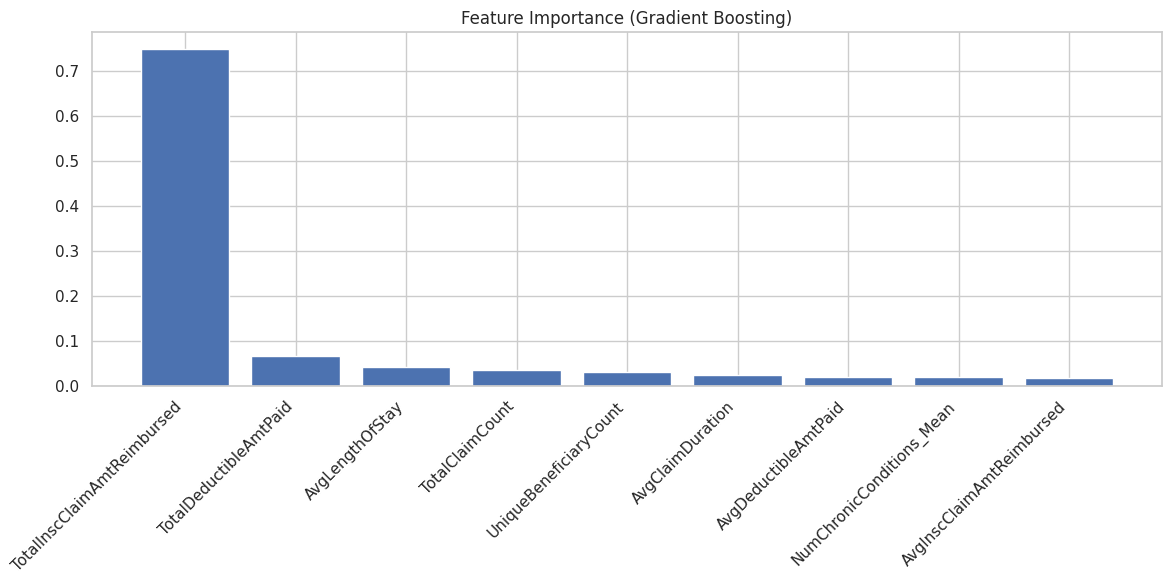

In [28]:
# --- 4. FEATURE IMPORTANCE (Chosen Best Model) ---
# Provides explainability for which behaviors drive fraud flags.

# Get the best model identified in the previous step
best_trained_model = results[best_model_name]['model']

# Check if the model has feature_importances_ (e.g., Tree-based models)
if hasattr(best_trained_model, 'feature_importances_'):
    importances = best_trained_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importance ({best_model_name})")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print(f"The chosen model ({best_model_name}) does not have a 'feature_importances_' attribute.")
    print("Feature importance is typically available for tree-based models like Random Forest or Gradient Boosting.")

In [29]:
# A. Save the Best Model
import joblib

# Assuming 'best_model_name' was defined (e.g., 'Random Forest')
# and 'results' dictionary holds the trained models.
best_model = results[best_model_name]['model']
joblib.dump(best_model, 'best_model.pkl')
print("Best model saved as 'best_model.pkl'")

Best model saved as 'best_model.pkl'


In [30]:
# B. Save the Test Dataset
import pandas as pd

# Save test features and labels
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Test data saved: X_test.csv, y_test.csv")

Test data saved: X_test.csv, y_test.csv


In [31]:
# C. Save Feature Names (Important for Interpretation)
import pandas as pd

# Save feature names for later analysis
feature_names = X_train.columns.tolist()
pd.Series(feature_names).to_csv('feature_names.csv', index=False)


Step 4: Evaluating the best model on the test set...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       981
           1       0.74      0.54      0.63       101

    accuracy                           0.94      1082
   macro avg       0.85      0.76      0.80      1082
weighted avg       0.93      0.94      0.94      1082



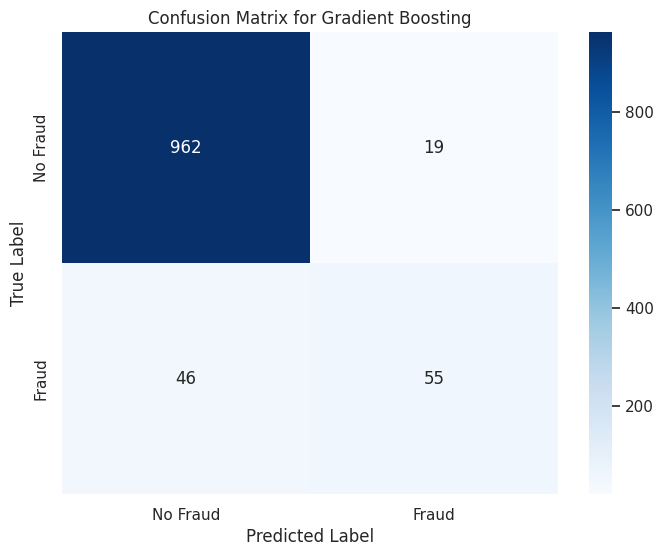

ROC AUC Score: 0.9536
Precision-Recall AUC (Average Precision Score): 0.6721


In [32]:
print("\nStep 4: Evaluating the best model on the test set...")

# 1. Retrieve the best trained model
best_trained_model = results[best_model_name]['model']

# 2. Make predictions on the scaled test set
y_pred = best_trained_model.predict(X_test_scaled)

# 3. Predict probabilities for the positive class
y_proba = best_trained_model.predict_proba(X_test_scaled)[:, 1]

# 4. Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 5. Generate and display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 6. Calculate ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# 7. Calculate Precision-Recall AUC (Average Precision Score)
pr_auc = average_precision_score(y_test, y_proba)
print(f"Precision-Recall AUC (Average Precision Score): {pr_auc:.4f}")

## Summary:

### Data Analysis Key Findings
*   The Gradient Boosting model achieved an overall accuracy of 94\% on the test set.
*   For the 'No Fraud' class, the model demonstrated high performance with 95\% precision, 98\% recall, and a 97\% f1-score.
*   For the 'Fraud' class, the model's performance was lower, showing 74\% precision, 54\% recall, and a 63\% f1-score.
*   The ROC AUC score was 0.9536, indicating good discrimination ability between the classes.
*   The Precision-Recall AUC (Average Precision Score) was 0.6721, providing a more relevant performance metric for the imbalanced dataset compared to ROC AUC.
